In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import sys
sys.path.append("..")
from utils import *
from merge_utils import *
import re
import gc
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn import preprocessing
import pickle

In [27]:
df_train = pickle.load(open('./data/df_train_pca.pkl', 'rb'))
df_test = pickle.load(open('./data/df_test_pca.pkl', 'rb'))
df_test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V75_pca_2,V75_pca_3,V75_pca_4,V75_pca_5,V75_pca_6,V75_pca_7,V75_pca_8,V75_pca_9,V75_pca_10,V75_pca_11
TransactionID,,,,,,,,,,,,,,,,,,,,,
3801080,23142547,2003.00000,W,10001,555.0,150.0,visa,226.0,credit,204.0,...,1.002983,0.996468,0.000974,0.002617,-0.001728,0.971559,1.024859,0.002978,0.000751,1.010253
3923735,27438765,51.21875,C,10002,302.0,150.0,visa,226.0,debit,NaN,...,1.012837,0.988689,1.002994,0.977146,1.019490,1.008515,0.992611,0.960818,1.029957,0.993839
4057742,31721781,226.00000,W,10002,302.0,150.0,visa,226.0,debit,428.0,...,1.003710,0.996835,-0.014661,0.003318,-0.002536,0.972411,1.025283,-0.005199,0.003284,2.002695
3668041,18562389,102.00000,W,10004,529.0,150.0,visa,162.0,credit,299.0,...,0.997801,1.001801,-0.017424,0.006418,-0.005269,0.973167,1.024372,0.006320,-0.006509,1.009853
3679185,18905741,248.50000,W,10004,529.0,150.0,visa,162.0,credit,220.0,...,0.991861,1.007462,-0.019057,-0.000482,0.001630,0.026245,-0.023231,-0.007524,0.002259,1.008038


In [35]:
iv_dict = {}
def worker(x):
    iv_dict[x] = count(df_train, x)[::-1]
    print(iv_dict[x])
for x in df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID']):
    worker(x)

In [5]:
list(df_train.columns)

['label',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'Date',
 '_Weekdays',
 '_Hours',
 '_Days',
 'Card_ID',
 'V217_pca_0',
 'V217_pca_1',
 'V217_pca_2',
 'V217_pca_3',


In [11]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_train["Date"] = df_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df_train['_Weekdays'] = df_train['Date'].dt.dayofweek
df_train['_Hours'] = df_train['Date'].dt.hour
df_train['_Days'] = df_train['Date'].dt.day

startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_test["Date"] = df_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df_test['_Weekdays'] = df_test['Date'].dt.dayofweek
df_test['_Hours'] = df_test['Date'].dt.hour
df_test['_Days'] = df_test['Date'].dt.day

In [12]:
df_test['label'] = np.nan
df = df_train.append(df_test)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [13]:
def newD(df_train):
    for i in range(1, 16):
        df_train['#test%i'%i] = (df_train['Date'] - pd.to_timedelta(df_train['D%i'%i], unit='d')).dt.strftime('%Y-%m-%d')
newD(df)

In [8]:
test = ['#test%i'%i for i in range(1, 16) if i !=9]
df[['Card_ID', 'Date', 'label']+test].sort_values(['Card_ID', 'Date'])

,Card_ID,Date,label,#test1,#test2,#test3,#test4,#test5,#test6,#test7,#test8,#test10,#test11,#test12,#test13,#test14,#test15
TransactionID,,,,,,,,,,,,,,,,,
3230924,1000 555 185 224 mastercard debit,2018-02-05 23:36:59,0.0,2018-02-05,NaT,NaT,2018-01-31,2018-01-31,2018-01-31,2018-01-31,2018-02-01,2018-02-05,NaT,2018-01-31,2018-01-31,2018-02-05,2018-01-31
3169988,10000 111 150 117 mastercard debit,2018-01-16 21:14:11,0.0,2017-10-25,2017-10-25,2017-11-07,2017-11-07,2017-11-07,NaT,NaT,NaT,2017-10-25,NaT,NaT,NaT,NaT,2017-10-25
3801080,10001 555 150 226 visa credit,2019-02-23 20:29:07,NaN,2019-02-23,NaT,NaT,2019-02-23,NaT,NaT,NaT,NaT,2019-02-23,2019-02-23,NaT,NaT,NaT,2019-02-23
3923735,10002 302 150 226 visa debit,2019-04-14 13:52:45,NaN,2019-04-14,NaT,NaT,2019-04-14,NaT,2019-04-14,NaT,2018-12-17,2019-04-14,NaT,2019-04-14,2019-04-14,2019-04-14,2019-04-14
4057742,10002 302 150 226 visa debit,2019-06-03 03:36:21,NaN,2019-06-03,NaT,NaT,2019-06-03,2019-06-03,NaT,NaT,NaT,2019-06-03,2019-06-03,NaT,NaT,NaT,2019-06-03
3328484,10003 555 128 226 visa debit,2018-03-08 11:23:35,0.0,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-08,NaT,2018-03-01,2018-03-01,2018-03-08,2018-03-08
3337343,10003 555 128 226 visa debit,2018-03-10 22:34:42,0.0,2018-03-01,2018-03-01,2018-03-08,NaT,NaT,NaT,NaT,2018-03-01,2018-03-10,NaT,NaT,2018-03-01,2018-03-10,NaT
3337365,10003 555 128 226 visa debit,2018-03-10 22:40:15,0.0,2018-03-01,2018-03-01,2018-03-10,NaT,NaT,NaT,NaT,2018-03-01,2018-03-10,NaT,NaT,2018-03-01,2018-03-10,NaT
3337822,10003 555 128 226 visa debit,2018-03-11 00:40:05,0.0,2018-03-01,2018-03-01,2018-03-11,NaT,NaT,NaT,NaT,2017-10-23,2018-03-11,NaT,NaT,2018-03-11,2018-03-11,NaT


In [28]:
df_train_raw = df_train.copy()
df_test_raw = df_test.copy()

In [23]:
df_train.head()

,label,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V75_pca_2,V75_pca_3,V75_pca_4,V75_pca_5,V75_pca_6,V75_pca_7,V75_pca_8,V75_pca_9,V75_pca_10,V75_pca_11
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,-10000.0,150.0,discover,142.0,credit,...,0.986679,1.012795,-0.037455,0.003319,-0.001911,0.027853,-0.023718,-0.004183,-0.005001,1.007637
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.993600,1.006083,-0.017020,0.008716,-0.008275,0.986622,1.012559,0.009654,-0.013967,1.004750
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.997801,1.001801,-0.017424,0.006418,-0.005269,0.973167,1.024372,0.006320,-0.006509,1.009853
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,0.997801,1.001801,-0.017424,0.006418,-0.005269,0.973167,1.024372,0.006320,-0.006509,1.009853
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000


In [106]:
cat_cols = ['id_%i'%x for x in range(12, 39)] + ['M%i'%x for x in range(1, 10)] + ['card%i'%i for i in range(1, 7)] + \
            [ 'DeviceType', 'DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2']
for col in cat_cols:
    if col in df_train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        #df_test[col] = le.transform(list(df_test[col].astype(str).values))  

In [32]:
def xgb_model_v3(params, df_train, df_val, df_test, features, label='label', num_boost_round=200):
    Dtrain = xgb.DMatrix(df_train[features], df_train[label])
    Dval = xgb.DMatrix(df_val[features], df_val[label])
    watchlist = [(Dtrain, 'train'), (Dval, 'val')]
    model = xgb.train(params, dtrain=Dtrain, early_stopping_rounds=100, 
                      evals=watchlist, num_boost_round=num_boost_round, verbose_eval=20)
    auc = model.best_score
    print('model best auc: %.4f at ntree_limit-%i'%(auc, model.best_ntree_limit))
    del Dtrain, Dval
    gc.collect()
#     Dtest = xgb.DMatrix(df_test[features])
#     pred = model.predict(Dtest, model.best_ntree_limit)
    return model, auc

In [159]:
def xgb_model_v4(params, df_train, df_val, df_test, features, label='label', num_boost_round=200):
    Dtrain = xgb.DMatrix(df_train[features], df_train[label])
    Dval = xgb.DMatrix(df_val[features], df_val[label])
    watchlist = [(Dtrain, 'train'), (Dval, 'val')]
    model = xgb.train(params, dtrain=Dtrain, early_stopping_rounds=100, 
                      evals=watchlist, num_boost_round=num_boost_round, verbose_eval=20)
    auc = model.best_score
    print('model best auc: %.4f at ntree_limit-%i'%(auc, model.best_ntree_limit))
    del Dtrain, Dval
    gc.collect()
    Dtest = xgb.DMatrix(df_test[features])
    pred = model.predict(Dtest, ntree_limit= model.best_ntree_limit)
    return model, auc, pred

In [277]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [163]:
id_cols =  [ 'DeviceType', 'DeviceInfo'] +  ['id_%i'%x for x in range(12, 39)]
id_index =  df_train[id_cols].notnull().any(axis=1)

In [141]:
basic_cols = ['label', 'TransactionDT', 'Date', 'Card_ID']

In [112]:
iv_dict_id = {}
for x in id_cols:
    iv_dict_id[x] = count(df_train[id_index], x, 20)[::-1]
    print(iv_dict_id[x])

(0.07180223677964762,             total       1      rate
DeviceType                         
0           85165  5554.0  0.065215
1           55645  5657.0  0.101662
2            3423   107.0  0.031259)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.18610509972665248,                   total       1      rate
DeviceInfo                               
(-0.001, 968.0]    7225   907.0  0.125536
(968.0, 1170.0]   14126   459.0  0.032493
(1170.0, 1199.0]    290    22.0  0.075862
(1199.0, 1841.0]   7299  1035.0  0.141800
(1841.0, 2216.0]   7126   750.0  0.105248
(2216.0, 2459.0]   9006   277.0  0.030757
(2459.0, 2526.0]  48133  3208.0  0.066649
(2526.0, 2599.0]    553    75.0  0.135624
(2599.0, 2693.0]  20393  1518.0  0.074437
(2693.0, 2740.0]  25668  2734.0  0.106514
(2740.0, 2799.0]   4414   333.0  0.075442)
(0.01268382706538767,         total        1      rate
id_12                           
0       21208   1269.0  0.059836
1      123025  10049.0  0.081683)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.07885813580365218,                 total       1      rate
id_13                                  
(-0.001, 10.0]   7984   588.0  0.073647
(10.0, 23.0]    15215  1901.0  0.124942
(23.0, 39.0]    28380  2097.0  0.073890
(39.0, 42.0]    58296  4358.0  0.074756
(42.0, 54.0]    17445  1644.0  0.094239
(54.0, 55.0]    16913   730.0  0.043162)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.31396055444994797,                total       1      rate
id_14                                 
(-0.001, 4.0]  44408  2203.0  0.049608
(4.0, 5.0]     16661   734.0  0.044055
(5.0, 6.0]      4542    72.0  0.015852
(6.0, 7.0]     12891   426.0  0.033046
(7.0, 13.0]      844    78.0  0.092417
(13.0, 28.0]   64887  7805.0  0.120286)
(0.1596643257078154,        total       1      rate
id_15                         
0      67728  7118.0  0.105097
1      61612  3034.0  0.049244
2      11645  1070.0  0.091885
3       3248    96.0  0.029557)
(0.15765770918297958,        total       1      rate
id_16                         
0      66324  7112.0  0.107231
1      63016  3040.0  0.048242
2      14893  1166.0  0.078292)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.33576070038011696,                 total       1      rate
id_17                                  
(-0.001, 65.0]  81614  3546.0  0.043448
(65.0, 122.0]   57740  7499.0  0.129875
(122.0, 127.0]   4879   273.0  0.055954)
(0.03480200847878858,        total       1      rate
id_18                         
0          1     0.0  0.000000
1         36     7.0  0.194444
2       4656   266.0  0.057131
3      13439   759.0  0.056477
4          3     0.0  0.000000
5      25489  2605.0  0.102201
6          1     0.0  0.000000
7        233     6.0  0.025751
8        650    42.0  0.064615
10       339    36.0  0.106195
11        78     1.0  0.012821
12         4     0.0  0.000000
13        52     6.0  0.115385
14         1     0.0  0.000000
15        89     2.0  0.022472
16        32     2.0  0.062500
17         1     0.0  0.000000
18         9     3.0  0.333333
19     99120  7583.0  0.076503)


C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

(0.314967402745171,                 total       1      rate
id_19                                  
(-0.001, 22.0]   7288   262.0  0.035950
(22.0, 76.0]     9976  1253.0  0.125601
(76.0, 114.0]    8931   290.0  0.032471
(114.0, 152.0]   5154   625.0  0.121265
(152.0, 163.0]  20022  2462.0  0.122965
(163.0, 187.0]   6375   763.0  0.119686
(187.0, 214.0]   8987   353.0  0.039279
(214.0, 249.0]   9131   781.0  0.085533
(249.0, 287.0]   4025   606.0  0.150559
(287.0, 307.0]  13290   442.0  0.033258
(307.0, 314.0]   4437   466.0  0.105026
(314.0, 324.0]   9059  1021.0  0.112706
(324.0, 351.0]   1565    51.0  0.032588
(351.0, 426.0]  12036   549.0  0.045613
(426.0, 438.0]   5495   323.0  0.058781
(438.0, 463.0]   4392   351.0  0.079918
(463.0, 529.0]   8113   342.0  0.042155
(529.0, 568.0]   5957   378.0  0.063455)


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')


(0.26186875337436155,                 total       1      rate
id_20                                  
(-0.001, 55.0]   7216   538.0  0.074557
(55.0, 111.0]   12011   420.0  0.034968
(111.0, 119.0]  11747   392.0  0.033370
(119.0, 163.0]   5285   235.0  0.044465
(163.0, 199.0]   7442   322.0  0.043268
(199.0, 218.0]  10267  1427.0  0.138989
(218.0, 228.0]   3771   404.0  0.107133
(228.0, 293.0]   8476   656.0  0.077395
(293.0, 378.0]   7763   417.0  0.053716
(378.0, 396.0]  25577  2659.0  0.103961
(396.0, 422.0]   7770   322.0  0.041441
(422.0, 424.0]   2120    91.0  0.042925
(424.0, 445.0]   5994   590.0  0.098432
(445.0, 455.0]   7927  1109.0  0.139902
(455.0, 484.0]   6630   773.0  0.116591
(484.0, 497.0]   7053   340.0  0.048206
(497.0, 547.0]   7184   623.0  0.086720)


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')


(0.0,                   total        1     rate
id_21                                    
(-0.001, 734.0]  144233  11318.0  0.07847)


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.0,                  total        1     rate
id_22                                   
(-0.001, 35.0]  144233  11318.0  0.07847)
(0.004590156259787172,         total        1      rate
id_23                           
0        1071    147.0  0.137255
1         609     34.0  0.055829
2        3489    245.0  0.070221
3      139064  10892.0  0.078324)


C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')


(0.004614288086853227,         total        1      rate
id_24                           
1        2817    265.0  0.094072
2           4      0.0  0.000000
5        1594     98.0  0.061481
6         220     14.0  0.063636
7           9      9.0  1.000000
8          37      0.0  0.000000
9           5      2.0  0.400000
11         33      2.0  0.060606
13          1      0.0  0.000000
14         12      6.0  0.500000
15          7      2.0  0.285714
16          8      4.0  0.500000
17     139486  10916.0  0.078259)


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')


(0.0,                   total        1     rate
id_25                                    
(-0.001, 440.0]  144233  11318.0  0.07847)


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.0,                   total        1     rate
id_26                                    
(-0.001, 115.0]  144233  11318.0  0.07847)
(1.4586083663966917e-05,         total        1      rate
id_27                           
0        5155    426.0  0.082638
1          14      0.0  0.000000
2      139064  10892.0  0.078324)
(0.13788782212343847,        total       1      rate
id_28                         
0      76232  7833.0  0.102752
1      64746  3385.0  0.052281
2       3255   100.0  0.030722)
(0.15138251929683277,        total       1      rate
id_29                         
0      74926  7827.0  0.104463
1      66052  3391.0  0.051338
2       3255   100.0  0.030722)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.3649672074525961,                 total       1      rate
id_30                                  
(-0.001, 13.0]   7439   627.0  0.084286
(13.0, 33.0]     8538   150.0  0.017569
(33.0, 49.0]    26200   805.0  0.030725
(49.0, 50.0]    13110   432.0  0.032952
(50.0, 54.0]     2471   179.0  0.072440
(54.0, 70.0]     8897   490.0  0.055075
(70.0, 73.0]     5476   361.0  0.065924
(73.0, 86.0]    72087  8265.0  0.114653
(86.0, 87.0]       15     9.0  0.600000)


C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.188582480532306,                 total       1      rate
id_31                                  
(-0.001, 46.0]  13394  1077.0  0.080409
(46.0, 47.0]     2097   161.0  0.076776
(47.0, 49.0]    22061  1504.0  0.068175
(49.0, 50.0]     5806   653.0  0.112470
(50.0, 53.0]    10406  1197.0  0.115030
(53.0, 55.0]     6917   679.0  0.098164
(55.0, 58.0]     7679   901.0  0.117333
(58.0, 76.0]     7321  1133.0  0.154760
(76.0, 85.0]     7493   348.0  0.046443
(85.0, 95.0]     4820   359.0  0.074481
(95.0, 123.0]   11505   390.0  0.033898
(123.0, 129.0]   3450   132.0  0.038261
(129.0, 130.0]  13423   842.0  0.062728
(130.0, 134.0]  12069  1163.0  0.096363
(134.0, 136.0]   4048   154.0  0.038043
(136.0, 155.0]   9678   447.0  0.046187
(155.0, 172.0]   2066   178.0  0.086157)
(0.3219574366435508,        total       1      rate
id_32                         
0          6     3.0  0.500000
1         81    18.0  0.222222
2      53071  1800.0  0.033917
3      24428  1630.0  0.066727
6      66647

C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(0.29558221208383156,                 total       1      rate
id_33                                  
(-0.001, 68.0]   8239   510.0  0.061901
(68.0, 80.0]     6513   381.0  0.058498
(80.0, 98.0]     9257   542.0  0.058550
(98.0, 156.0]    8163   263.0  0.032219
(156.0, 216.0]  18828   522.0  0.027725
(216.0, 267.0]  10877   644.0  0.059208
(267.0, 313.0]   4470   232.0  0.051902
(313.0, 409.0]   5881   125.0  0.021255
(409.0, 461.0]  72005  8099.0  0.112478)
(0.28467114478090083,        total       1      rate
id_34                         
0          3     0.0  0.000000
1        415    21.0  0.050602
2      17376  1106.0  0.063651
3      60011  2358.0  0.039293
4      66428  7833.0  0.117917)


C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.2990832238094536,        total       1      rate
id_35                         
0      63171  7745.0  0.122604
1      77814  3477.0  0.044683
2       3248    96.0  0.029557)
(0.041930816719822725,         total        1      rate
id_36                           
0      134066  10978.0  0.081885
1        6919    244.0  0.035265
2        3248     96.0  0.029557)
(0.0256312733193644,         total       1      rate
id_37                          
0       30533  2020.0  0.066158
1      110452  9202.0  0.083312
2        3248    96.0  0.029557)
(0.08478204273763008,        total       1      rate
id_38                         
0      73922  7229.0  0.097792
1      67063  3993.0  0.059541
2       3248    96.0  0.029557)


In [115]:
[x for x in id_map_cols if iv_dict_id[x][0]>0.1]

['id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35']

In [61]:
df_train['#test1'] = (df_train['DeviceType'].notnull())&(df_train['DeviceInfo'].isnull())
count(df_train, '#test')

(        total        1      rate
 #test                           
 False  580066  19527.0  0.033663
 True    10474   1136.0  0.108459, 0.04825952165648504)

In [108]:
id_map_cols = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35',
              'id_36', 'id_37', 'id_38']

In [164]:
cat_cols = ['id_%i'%x for x in range(12, 39)] + ['M%i'%x for x in range(1, 10)] + \
            [ 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']
for col in cat_cols:
    if col in df_train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))  
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.1,                  
    'max_depth': 20,  
    #'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.7,       
    'min_child_weight': 100,
    'reg_alpha': 5.,
    'reg_lambda': 5.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
folds = TimeSeriesSplit(n_splits=5)
f = [x for x in df_train.columns if 'pca_0' in x] + [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
                                                    if x[0]!='V']
print(len(f))
auc_lst = []
preds = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    model, auc, pred = xgb_model_v4(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    preds.append(pred)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

110
[0]	train-auc:0.90453	val-auc:0.807559
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.962056	val-auc:0.873876
[40]	train-auc:0.973494	val-auc:0.883718
[60]	train-auc:0.98245	val-auc:0.889715
[80]	train-auc:0.988067	val-auc:0.893662
[100]	train-auc:0.991851	val-auc:0.895303
[120]	train-auc:0.994054	val-auc:0.896729
[140]	train-auc:0.99553	val-auc:0.897666
[160]	train-auc:0.996551	val-auc:0.898041
[180]	train-auc:0.997249	val-auc:0.897659
[200]	train-auc:0.997778	val-auc:0.897688
[220]	train-auc:0.998146	val-auc:0.898322
[240]	train-auc:0.998418	val-auc:0.898134
[260]	train-auc:0.998639	val-auc:0.898044
[280]	train-auc:0.998836	val-auc:0.89791
[300]	train-auc:0.998974	val-auc:0.897977
[320]	train-auc:0.999086	val-auc:0.89759
Stopping. Best iteration:
[229]	train-auc:0.998291	val-auc:0.89852

model best auc: 0.8985 at ntree_limit-230
[0]	train-auc:0.911339	val-auc:0.835894
Mul

In [165]:
pred1 = np.mean(np.array(preds), axis=0)
pred1.shape

(506691,)

In [170]:
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.1,                  
    'max_depth': 20,  
    #'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.7,       
    'min_child_weight': 100,
    'reg_alpha': 5.,
    'reg_lambda': 5.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
folds = KFold(n_splits=5, shuffle=True)
f = [x for x in df_train.columns if 'pca_0' in x] + [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
                                                    if x[0]!='V']
print(len(f))
auc_lst = []
preds = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    model, auc, pred = xgb_model_v4(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    preds.append(pred)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

110
[0]	train-auc:0.912906	val-auc:0.881301
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.965126	val-auc:0.929436
[40]	train-auc:0.975072	val-auc:0.936761
[60]	train-auc:0.981925	val-auc:0.943863
[80]	train-auc:0.986692	val-auc:0.949279
[100]	train-auc:0.989446	val-auc:0.953134
[120]	train-auc:0.991295	val-auc:0.955705
[140]	train-auc:0.992961	val-auc:0.957607
[160]	train-auc:0.994093	val-auc:0.959079
[180]	train-auc:0.994941	val-auc:0.960197
[200]	train-auc:0.995683	val-auc:0.961116
[220]	train-auc:0.996224	val-auc:0.961712
[240]	train-auc:0.996743	val-auc:0.96272
[260]	train-auc:0.997069	val-auc:0.963207
[280]	train-auc:0.9974	val-auc:0.963847
[300]	train-auc:0.997717	val-auc:0.964334
[320]	train-auc:0.997968	val-auc:0.964787
[340]	train-auc:0.998133	val-auc:0.965022
[360]	train-auc:0.998293	val-auc:0.96521
[380]	train-auc:0.998463	val-auc:0.965427
[400]	train-auc:0.998586	v

In [171]:
pred2 = np.mean(np.array(preds), axis=0)
pred2.shape

(506691,)

In [179]:
df_test['isFraud'] = pred1+pred2
df_test[['isFraud']].to_csv('./result/pca.csv')

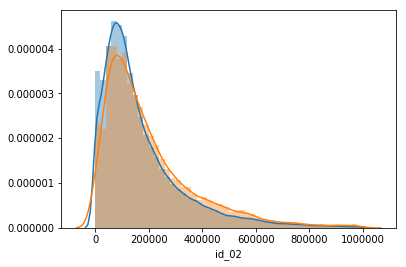

In [130]:
df_train['#id_02'] = np.log1p(df_train['id_02'])
import seaborn as sns
def distplotLabel(df, f, label='label'):
    notnull = df[f].notnull()
    sns.distplot(df.loc[(df[label]==0)&notnull, f], bins=50)
    sns.distplot(df.loc[(df[label]==1) &notnull, f], bins=50)
    plt.show()
distplotLabel(df_train, '#id_02')

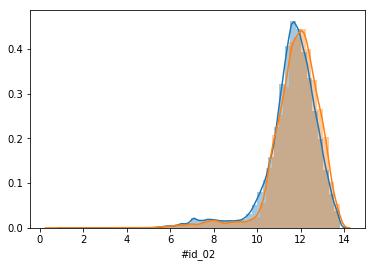

In [203]:
df_train['#id_02'] = np.log1p(df_train['id_02'])
import seaborn as sns
def distplotLabel(df, f, bins=50, label='label'):
    notnull = df[f].notnull()
    sns.distplot(df.loc[(df[label]==0)&notnull, f], bins=bins)
    sns.distplot(df.loc[(df[label]==1) &notnull, f], bins=bins)
    plt.show()
distplotLabel(df_train, '#id_02')

In [134]:
id_all_cols = [x for x in df.columns if x.startswith('id_') or x.startswith('Device')]

In [180]:
model.get_score(importance_type='weight')

{'C1': 1709,
 'C10': 263,
 'C11': 1201,
 'C12': 386,
 'C13': 2818,
 'C14': 1320,
 'C2': 1774,
 'C3': 16,
 'C4': 146,
 'C5': 596,
 'C6': 1347,
 'C7': 78,
 'C8': 249,
 'C9': 1007,
 'D1': 2346,
 'D10': 2890,
 'D11': 2720,
 'D12': 342,
 'D13': 284,
 'D14': 654,
 'D15': 4194,
 'D2': 2949,
 'D3': 2214,
 'D4': 3532,
 'D5': 2160,
 'D6': 391,
 'D7': 285,
 'D8': 1617,
 'D9': 701,
 'DeviceInfo': 1167,
 'DeviceType': 297,
 'M1': 129,
 'M2': 223,
 'M3': 427,
 'M4': 1420,
 'M5': 1337,
 'M6': 1485,
 'M7': 937,
 'M8': 802,
 'M9': 287,
 'P_emaildomain': 3347,
 'ProductCD': 362,
 'R_emaildomain': 1079,
 'TransactionAmt': 8945,
 'V12_pca_0': 2776,
 'V138_pca_0': 300,
 'V143_pca_0': 511,
 'V167_pca_0': 377,
 'V169_pca_0': 672,
 'V1_pca_0': 1582,
 'V217_pca_0': 856,
 'V220_pca_0': 747,
 'V279_pca_0': 2042,
 'V281_pca_0': 2142,
 'V322_pca_0': 294,
 'V35_pca_0': 3011,
 'V53_pca_0': 3443,
 'V75_pca_0': 3900,
 'V95_pca_0': 1252,
 '_Days': 6255,
 '_Hours': 5249,
 '_Weekdays': 3583,
 'addr1': 6892,
 'addr2': 55,

In [249]:
#iv_dict = pickle.load(open('./result/iv_dict.pkl', 'rb'))
iv_dict['TransactionAmt']

(0.1181865764367441,                    total       1      rate
 TransactionAmt                            
 (0.25, 25.953]     59515  3326.0  0.055885
 (25.953, 35.938]   61646  1976.0  0.032054
 (35.938, 49.0]     65117  2100.0  0.032250
 (49.0, 57.938]     59648  1159.0  0.019431
 (57.938, 68.75]    49345  1407.0  0.028514
 (68.75, 100.0]     73351  2653.0  0.036169
 (100.0, 117.0]     72081  1423.0  0.019742
 (117.0, 160.0]     32479  1398.0  0.043043
 (160.0, 275.25]    58305  2217.0  0.038024
 (275.25, 31936.0]  59053  3004.0  0.050870)

In [265]:
df_train['#test'] = df_train['TransactionAmt']-df_train.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
count(df_train, '#test')

(                     total       1      rate
 #test                                       
 (-2296.001, -122.5]  59095  1787.0  0.030239
 (-122.5, -86.25]     59194  1315.0  0.022215
 (-86.25, -67.688]    59110  1006.0  0.017019
 (-67.688, -51.688]   58883  1103.0  0.018732
 (-51.688, -33.344]   59009  1502.0  0.025454
 (-33.344, -17.062]   59068  2983.0  0.050501
 (-17.062, 0.0]       64284  2913.0  0.045315
 (0.0, 28.125]        53874  2418.0  0.044883
 (28.125, 112.25]     58974  2903.0  0.049225
 (112.25, 31648.0]    59049  2733.0  0.046284, 0.1575303881372511)

In [264]:
df_train['#test'] = df_train['TransactionAmt']-df_train.groupby(['card1','ProductCD'])['TransactionAmt'].transform('median')
count(df_train, '#test')

(                    total       1      rate
 #test                                      
 (-2848.001, -47.5]  59186  1214.0  0.020512
 (-47.5, -27.719]    58924  1018.0  0.017276
 (-27.719, -16.516]  59059  1865.0  0.031579
 (-16.516, -5.031]   59244  2266.0  0.038249
 (-5.031, 0.0]       85887  2805.0  0.032659
 (0.0, 10.0]         32428  1580.0  0.048723
 (10.0, 36.062]      58720  2561.0  0.043614
 (36.062, 62.156]    58985  2052.0  0.034789
 (62.156, 161.0]     59108  2550.0  0.043141
 (161.0, 31776.0]    58999  2752.0  0.046645, 0.09330731453401198)

In [199]:
df_train['#test'] = df_train['TransactionAmt']-df_train.groupby('ProductCD')['TransactionAmt'].transform('mean')
count(df_train, '#test')

(                     total       1      rate
 #test                                       
 (-152.126, -118.25]  61030   697.0  0.011421
 (-118.25, -104.125]  63262   988.0  0.015618
 (-104.125, -94.125]  75526  1048.0  0.013876
 (-94.125, -68.25]    45241   781.0  0.017263
 (-68.25, -45.188]    59470  1146.0  0.019270
 (-45.188, -35.281]   49950  1237.0  0.024765
 (-35.281, -12.062]   58911  4061.0  0.068934
 (-12.062, 29.438]    59050  4070.0  0.068925
 (29.438, 126.875]    60894  3569.0  0.058610
 (126.875, 31776.0]   57206  3066.0  0.053596, 0.4821201864594953)

In [191]:
df_train['#test'] = (df_train['#TransactionAmt']-df_train.groupby('ProductCD')['#TransactionAmt'].transform('mean'))/ \
            df_train.groupby('ProductCD')['#TransactionAmt'].transform('std')
count(df_train, '#test')

(                  total       1      rate
 #test                                    
 (-4.274, -1.179]  65054  1450.0  0.022289
 (-1.179, -0.796]  53784  1340.0  0.024914
 (-0.796, -0.493]  81530  1713.0  0.021011
 (-0.493, -0.476]  48342   955.0  0.019755
 (-0.476, -0.125]  48193  1809.0  0.037537
 (-0.125, 0.192]   73655  2306.0  0.031308
 (0.192, 0.279]    43523  1159.0  0.026630
 (0.279, 0.821]    61354  3112.0  0.050722
 (0.821, 1.37]     57812  2864.0  0.049540
 (1.37, 6.543]     57293  3955.0  0.069031, 0.191610913608595)

In [275]:
cat_cols = ['id_%i'%x for x in range(12, 39)] + ['M%i'%x for x in range(1, 10)] + \
            [ 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']
# for col in cat_cols:
#     if col in df_train.columns:
#         le = preprocessing.LabelEncoder()
#         le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
#         df_train[col] = le.transform(list(df_train[col].astype(str).values))
#         #df_test[col] = le.transform(list(df_test[col].astype(str).values))  
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.1,                  
    'max_depth': 20,  
    #'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.7,       
    'min_child_weight': 100,
    'reg_alpha': 5.,
    'reg_lambda': 5.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
folds = TimeSeriesSplit(n_splits=5)
f = [x for x in df_train.columns if 'pca_0' in x] + [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
                                                    if x[0]!='V' ]
to_drop = id_all_cols
f = list(set(f)-set(to_drop))
#f.remove('ProductCD')
print(len(f))
auc_lst = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    model, auc = xgb_model_v3(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

125
[0]	train-auc:0.895548	val-auc:0.804389
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.963479	val-auc:0.877422
[40]	train-auc:0.975197	val-auc:0.884646
[60]	train-auc:0.98371	val-auc:0.891184
[80]	train-auc:0.98907	val-auc:0.895136
[100]	train-auc:0.992415	val-auc:0.89678
[120]	train-auc:0.994543	val-auc:0.898125
[140]	train-auc:0.996067	val-auc:0.899057
[160]	train-auc:0.996944	val-auc:0.899518
[180]	train-auc:0.997638	val-auc:0.899908
[200]	train-auc:0.998075	val-auc:0.899987
[220]	train-auc:0.998435	val-auc:0.900031
[240]	train-auc:0.998675	val-auc:0.900227
[260]	train-auc:0.998873	val-auc:0.900256
[280]	train-auc:0.99905	val-auc:0.900076
[300]	train-auc:0.999162	val-auc:0.900028
[320]	train-auc:0.999277	val-auc:0.899761
[340]	train-auc:0.999362	val-auc:0.899739
[360]	train-auc:0.999435	val-auc:0.899374
Stopping. Best iteration:
[266]	train-auc:0.998934	val-auc:0.900368


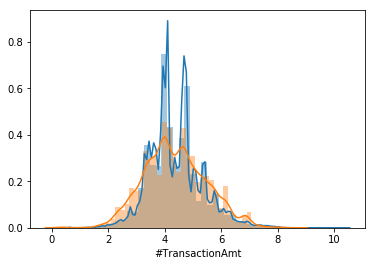

In [218]:
def distplotLabel(df, f, label='label', **kargs):
    notnull = df[f].notnull()
    plt.figure(figsize=(14,22))
    sns.distplot(df.loc[(df[label]==0)&notnull, f], **kargs)
    sns.distplot(df.loc[(df[label]==1) &notnull, f], **kargs)
    plt.show()
df_train['#TransactionAmt'] = np.log1p(df_train['TransactionAmt'])
distplotLabel(df_train, '#TransactionAmt', bins=50, rug=False)

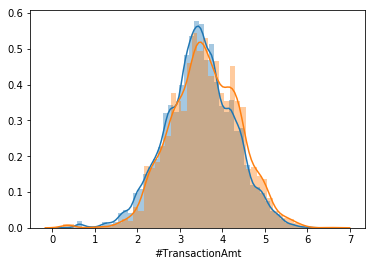

In [221]:
distplotLabel(df_train[df_train['ProductCD']=='C'], '#TransactionAmt')

In [234]:
tmp = df_train['ProductCD']=='H'
count(df_train[tmp], 'TransactionAmt', 10)

C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(                total      1      rate
 TransactionAmt                        
 (14.999, 25.0]   6227   96.0  0.015417
 (25.0, 30.0]     1676    9.0  0.005370
 (30.0, 45.0]     2064   15.0  0.007267
 (45.0, 50.0]     9845  233.0  0.023667
 (50.0, 51.0]        9    0.0  0.000000
 (51.0, 100.0]    8999  382.0  0.042449
 (100.0, 150.0]   2484  417.0  0.167874
 (150.0, 500.0]   1720  422.0  0.245349, 1.187779595108763)

In [239]:
tmp = df_train['ProductCD']=='R'
count(df_train[tmp], 'TransactionAmt', 20)

C:\Users\admin\Desktop\FraudDetection\utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['#tmp#'] = pd.qcut(df[attr], q=bins, duplicates='drop')
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(                 total      1      rate
 TransactionAmt                         
 (24.999, 50.0]    4083   54.0  0.013226
 (50.0, 75.0]      1791   19.0  0.010609
 (75.0, 100.0]    11836  186.0  0.015715
 (100.0, 125.0]    1766   32.0  0.018120
 (125.0, 150.0]    5655  130.0  0.022989
 (150.0, 200.0]    5590  360.0  0.064401
 (200.0, 250.0]    2852  195.0  0.068373
 (250.0, 300.0]    1584  174.0  0.109848
 (300.0, 400.0]     761  143.0  0.187911
 (400.0, 1800.0]   1781  133.0  0.074677, 0.7247397775796527)

In [270]:
for x in cat_cols:
    df_train['#test_%s'%x] = df_train['TransactionAmt']-df_train.groupby(x)['TransactionAmt'].transform('mean')
    print(count(df_train, '#test_%s'%x))

(                      total       1      rate
#test_id_12                                  
(-151.251, -117.625]  59170   804.0  0.013588
(-117.625, -102.625]  67678  1217.0  0.017982
(-102.625, -92.625]   78245  1203.0  0.015375
(-92.625, -71.625]    31253   779.0  0.024926
(-71.625, -51.188]    59023  3336.0  0.056520
(-51.188, -36.562]    60429  2377.0  0.039335
(-36.562, -20.397]    57580  2265.0  0.039337
(-20.397, 23.438]     59482  2727.0  0.045846
(23.438, 128.375]     59117  2812.0  0.047567
(128.375, 31792.0]    58563  3143.0  0.053669, 0.2519792546000659)
(                    total       1      rate
#test_id_13                                
(-148.126, -114.5]  64777   956.0  0.014758
(-114.5, -99.5]     67005  1094.0  0.016327
(-99.5, -90.562]    46383   527.0  0.011362
(-90.562, -75.5]    58437  2037.0  0.034858
(-75.5, -51.5]      62033  3089.0  0.049796
(-51.5, -40.0]      58029  1610.0  0.027745
(-40.0, -18.0]      57932  2675.0  0.046175
(-18.0, 30.5]       57856  28

(                      total       1      rate
#test_id_27                                  
(-135.126, -109.188]  59055  3318.0  0.056185
(-109.188, -99.438]   60664  1909.0  0.031468
(-99.438, -86.375]    65208  2102.0  0.032235
(-86.375, -77.438]    59247  1170.0  0.019748
(-77.438, -66.375]    51280  1447.0  0.028218
(-66.375, -35.375]    71808  2608.0  0.036319
(-35.375, -18.375]    72342  1446.0  0.019988
(-18.375, 24.625]     33162  1382.0  0.041674
(24.625, 141.375]     58724  2238.0  0.038110
(141.375, 31808.0]    59050  3043.0  0.051533, 0.11769248543944369)
(                      total       1      rate
#test_id_28                                  
(-150.751, -117.125]  60065   806.0  0.013419
(-117.125, -102.125]  65685  1068.0  0.016259
(-102.125, -92.125]   76415  1096.0  0.014343
(-92.125, -72.75]     34097  1780.0  0.052204
(-72.75, -51.125]     61043  3563.0  0.058369
(-51.125, -40.438]    59903  1751.0  0.029231
(-40.438, -16.125]    57233  2332.0  0.040746
(-16.125, 

(                      total       1      rate
#test_M4                                     
(-151.376, -115.188]  59200  1076.0  0.018176
(-115.188, -101.5]    64647  1220.0  0.018872
(-101.5, -91.5]       53473   734.0  0.013727
(-91.5, -76.5]        74892  1687.0  0.022526
(-76.5, -52.125]      47525  1242.0  0.026134
(-52.125, -37.75]     54715  1672.0  0.030558
(-37.75, -18.5]       65777  3323.0  0.050519
(-18.5, 32.875]       52305  3903.0  0.074620
(32.875, 140.512]     58952  2724.0  0.046207
(140.512, 31776.0]    59054  3082.0  0.052190, 0.2841874172213275)
(                    total       1      rate
#test_M5                                   
(-152.126, -108.0]  59112  3058.0  0.051732
(-108.0, -97.875]   59068  1966.0  0.033284
(-97.875, -86.25]   64512  2007.0  0.031110
(-86.25, -76.125]   54609  1602.0  0.029336
(-76.125, -65.125]  58123  1325.0  0.022796
(-65.125, -36.125]  68004  2313.0  0.034013
(-36.125, -23.312]  55993  1172.0  0.020931
(-23.312, 20.75]    53236  19

(                      total       1      rate
#test_card3                                  
(-654.001, -115.562]  60403  1148.0  0.019006
(-115.562, -98.562]   60933   850.0  0.013950
(-98.562, -88.562]    74059  1176.0  0.015879
(-88.562, -78.562]    44411   810.0  0.018239
(-78.562, -46.5]      68579  1808.0  0.026364
(-46.5, -33.219]      45956   888.0  0.019323
(-33.219, -15.469]    59179  3212.0  0.054276
(-15.469, 24.5]       61406  4366.0  0.071101
(24.5, 133.5]         59010  3410.0  0.057787
(133.5, 31792.0]      56604  2995.0  0.052911, 0.37078764691628263)
(                      total       1      rate
#test_card5                                  
(-667.001, -112.125]  63083  3072.0  0.048698
(-112.125, -93.188]   58351  1640.0  0.028106
(-93.188, -83.188]    56380  1324.0  0.023484
(-83.188, -67.375]    58533  1492.0  0.025490
(-67.375, -50.406]    58927  1556.0  0.026406
(-50.406, -33.188]    67545  1889.0  0.027967
(-33.188, -14.25]     51025  1944.0  0.038099
(-14.25, 2

In [278]:
E = FeatureEncode('label')
E.main_trans(df_train)
E.main_id(df_train)

iv=0.5576
                   total       1      rate
ProductCD#encode                          
W                 439670  8969.0  0.020399
R                  37699  1426.0  0.037826
H                  33024  1574.0  0.047662
S                  11628   686.0  0.058996
C                  68519  8008.0  0.116873
iv=0.5220
                total       1      rate
addr1#encode                           
 494.000000    5065.0    40.0  0.007897
 205.000000    5725.0    64.0  0.011179
 143.000000    9806.0   124.0  0.012645
 436.000000    3169.0    41.0  0.012938
 184.000000   15160.0   206.0  0.013588
 191.000000   14979.0   249.0  0.016623
 315.000000   23078.0   411.0  0.017809
 264.000000   39870.0   728.0  0.018259
 387.000000    8187.0   157.0  0.019177
 327.000000    8425.0   164.0  0.019466
 485.000000    6816.0   134.0  0.019660
 310.000000    8486.0   167.0  0.019679
 110.000000    3220.0    64.0  0.019876
 433.000000    7831.0   160.0  0.020432
 299.000000   46335.0   985.0  0.021258

C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


iv=0.2510
                 total        1      rate
card6#encode                             
999999            45.0      0.0  0.000000
debit         439938.0  10674.0  0.024263
NaN             1571.0     39.0  0.024825
credit        148986.0   9950.0  0.066785
iv=0.2455
              total        1      rate
M1#encode                             
999999         25.0      0.0  0.000000
T          319415.0   6342.0  0.019855
NaN        271100.0  14321.0  0.052826
iv=0.2687
              total        1      rate
M2#encode                             
T          285468.0   5158.0  0.018069
F           33972.0   1184.0  0.034852
NaN        271100.0  14321.0  0.052826
iv=0.2737
              total        1      rate
M3#encode                             
T          251731.0   4293.0  0.017054
F           67709.0   2049.0  0.030262
NaN        271100.0  14321.0  0.052826
iv=0.4559
              total       1      rate
M4#encode                            
NaN        281444.0  5227.0  0.018572

iv=0.5413
                            total       1      rate
id_31#encode                                       
ie 11.0 for desktop        9030.0   175.0  0.019380
NaN                      450258.0  9492.0  0.021081
safari generic             8195.0   205.0  0.025015
edge 16.0                  4188.0   115.0  0.027459
chrome 62.0                7182.0   299.0  0.041632
firefox 57.0               3315.0   184.0  0.055505
mobile safari 11.0        13423.0   842.0  0.062728
chrome 63.0               22000.0  1503.0  0.068318
chrome 64.0                6711.0   615.0  0.091641
chrome 66.0                4264.0   398.0  0.093340
999999                    26236.0  2511.0  0.095708
chrome 65.0                6871.0   679.0  0.098821
mobile safari generic     11474.0  1146.0  0.099878
chrome 63.0 for android    5806.0   653.0  0.112470
chrome 65.0 for android    3336.0   491.0  0.147182
chrome 64.0 for android    3473.0   552.0  0.158940
chrome generic             4778.0   803.0  0.168062
iv

In [279]:
df_train.columns

Index(['label', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_29#encode', 'id_30#encode', 'id_31#encode', 'id_32#encode',
       'id_33#encode', 'id_34#encode', 'id_35#encode', 'id_36#encode',
       'id_37#encode', 'id_38#encode'],
      dtype='object', length=238)

In [281]:
cat_cols = ['id_%i'%x for x in range(12, 39)] + ['M%i'%x for x in range(1, 10)] + \
            [ 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']
# for col in cat_cols:
#     if col in df_train.columns:
#         le = preprocessing.LabelEncoder()
#         le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
#         df_train[col] = le.transform(list(df_train[col].astype(str).values))
#         #df_test[col] = le.transform(list(df_test[col].astype(str).values))  
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.1,                  
    'max_depth': 20,  
    #'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.7,       
    'min_child_weight': 100,
    'reg_alpha': 5.,
    'reg_lambda': 5.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
folds = TimeSeriesSplit(n_splits=5)
f = [x for x in df_train.columns if 'pca_0' in x] + [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
                                                    if x[0]!='V' ] 
to_drop = cat_cols
f = list(set(f)-set(to_drop))
#f.remove('ProductCD')
print(len(f))
auc_lst = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    train_tmp = df_train.iloc[train_index, :].copy()
    val_tmp = df_train.iloc[valid_index, :].copy()
    E = FeatureEncode('label')
    E.main_trans(train_tmp)
    E.main_trans(val_tmp)
    E.main_id(train_tmp)
    E.main_id(val_tmp)
    model, auc = xgb_model_v3(params, train_tmp,val_tmp, df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

110
iv=0.5092
                  total       1      rate
ProductCD#encode                         
R                 13432   147.0  0.010944
W                 56164  1038.0  0.018482
H                 15260   299.0  0.019594
999999             2504    59.0  0.023562
C                 11065   986.0  0.089110
iv=0.3503
                total      1      rate
addr1#encode                          
 330.000000    4222.0   54.0  0.012790
 441.000000    3465.0   54.0  0.015584
 264.000000    6423.0  101.0  0.015725
 299.000000    8783.0  139.0  0.015826
 inf          46200.0  953.0  0.020628
 315.000000    3769.0   85.0  0.022552
 325.000000    6745.0  155.0  0.022980
 204.000000    6954.0  160.0  0.023008
 272.000000    3119.0   75.0  0.024046
NaN            8745.0  753.0  0.086106
iv=0.4858
                total       1      rate
addr2#encode                           
 87.000000    87078.0  1529.0  0.017559
NaN            8745.0   753.0  0.086106
 inf           2602.0   247.0  0.094927
iv=0

C:\Users\admin\Desktop\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


iv=0.0920
                total       1      rate
card6#encode                           
999999           10.0     0.0  0.000000
debit         63861.0  1278.0  0.020012
credit        34550.0  1249.0  0.036151
NaN               4.0     2.0  0.500000
iv=0.0612
             total       1      rate
M1#encode                           
T          31020.0   530.0  0.017086
NaN        67405.0  1999.0  0.029657
iv=0.0815
             total       1      rate
M2#encode                           
T          27911.0   426.0  0.015263
NaN        67405.0  1999.0  0.029657
F           3109.0   104.0  0.033451
iv=0.0911
             total       1      rate
M3#encode                           
T          24262.0   335.0  0.013808
F           6758.0   195.0  0.028855
NaN        67405.0  1999.0  0.029657
iv=0.6158
             total      1      rate
M4#encode                          
NaN        56802.0  650.0  0.011443
M1          6628.0  133.0  0.020066
M0         25826.0  938.0  0.036320
M2          

iv=0.0919
                total       1      rate
id_37#encode                           
NaN           58827.0  1141.0  0.019396
F              8643.0   286.0  0.033090
T             30955.0  1102.0  0.035600
iv=0.1673
                total       1      rate
id_38#encode                           
F             10195.0   152.0  0.014909
NaN           58827.0  1141.0  0.019396
T             29403.0  1236.0  0.042037
[0]	train-auc:0.913668	val-auc:0.753459
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.968291	val-auc:0.871987
[40]	train-auc:0.977956	val-auc:0.873683
[60]	train-auc:0.983811	val-auc:0.872636
[80]	train-auc:0.98786	val-auc:0.871801
[100]	train-auc:0.991003	val-auc:0.872991
[120]	train-auc:0.992992	val-auc:0.874181
[140]	train-auc:0.994438	val-auc:0.873894
Stopping. Best iteration:
[43]	train-auc:0.979199	val-auc:0.875673

model best auc: 0.8757 at ntree_limit-44
iv

iv=0.2319
                 total       1      rate
id_13#encode                            
NaN           139034.0  2876.0  0.020686
 49.000000     20457.0   905.0  0.044239
 52.000000     28212.0  1306.0  0.046292
 inf            9145.0   749.0  0.081903
iv=0.0115
                 total       1      rate
id_14#encode                            
-480.000000     8014.0   159.0  0.019840
 inf            3764.0    76.0  0.020191
-300.000000    25289.0   675.0  0.026691
-360.000000    10363.0   291.0  0.028081
NaN           149418.0  4635.0  0.031020
iv=0.2769
                 total       1      rate
id_15#encode                            
NaN           128952.0  2554.0  0.019806
New            32276.0   961.0  0.029774
Found          31305.0  2032.0  0.064910
Unknown         4315.0   289.0  0.066976
iv=0.2374
                 total       1      rate
id_16#encode                            
NaN           133267.0  2843.0  0.021333
NotFound       33347.0   964.0  0.028908
Found          30

iv=0.4188
                 total       1      rate
addr2#encode                            
 87.000000    259495.0  6150.0  0.023700
 inf            2977.0   272.0  0.091367
NaN            32799.0  3472.0  0.105857
iv=0.1169
                         total       1      rate
P_emaildomain#encode                            
comcast.net             4341.0    53.0  0.012209
aol.com                14245.0   293.0  0.020569
yahoo.com              49467.0  1112.0  0.022480
anonymous.com          20168.0   459.0  0.022759
NaN                    46657.0  1215.0  0.026041
999999                 24801.0   678.0  0.027338
gmail.com             111569.0  4835.0  0.043336
hotmail.com            24023.0  1249.0  0.051992
iv=0.4663
                         total       1      rate
R_emaildomain#encode                            
NaN                   213132.0  4284.0  0.020100
anonymous.com          13016.0   375.0  0.028811
999999                 13003.0   532.0  0.040914
yahoo.com               7042.0

iv=0.4427
                 total       1      rate
id_19#encode                            
 312.000000     4703.0    93.0  0.019775
 100.000000     3913.0    79.0  0.020189
NaN           209888.0  4403.0  0.020978
 215.000000     3477.0    73.0  0.020995
 410.000000     7626.0   210.0  0.027537
 529.000000     5672.0   168.0  0.029619
 542.000000     3774.0   224.0  0.059353
 inf           41983.0  3045.0  0.072529
 427.000000     4397.0   383.0  0.087105
 266.000000     9838.0  1216.0  0.123602
iv=0.4113
                 total       1      rate
id_20#encode                            
NaN           209892.0  4403.0  0.020977
 222.000000     7765.0   224.0  0.028847
 214.000000     4104.0   142.0  0.034600
 533.000000     3566.0   156.0  0.043746
 600.000000     4003.0   178.0  0.044467
 inf           44404.0  2417.0  0.054432
 549.000000     3944.0   298.0  0.075558
 507.000000    13856.0  1544.0  0.111432
 325.000000     3737.0   532.0  0.142360
iv=0.0104
                 total     

iv=0.4836
                         total       1      rate
R_emaildomain#encode                            
NaN                   295503.0  6255.0  0.021167
anonymous.com          15251.0   426.0  0.027933
aol.com                 3003.0   108.0  0.035964
999999                 12196.0   579.0  0.047475
yahoo.com               8058.0   424.0  0.052619
hotmail.com            19161.0  1432.0  0.074735
gmail.com              40522.0  4356.0  0.107497
iv=0.0475
               total        1      rate
card1#encode                           
7919            9704     85.0  0.008759
2803            4040     51.0  0.012624
12839           3323     60.0  0.018056
12544           4430     92.0  0.020767
12695           4547    100.0  0.021993
17188           6816    209.0  0.030663
9500            9222    316.0  0.034266
16959         323607  11460.0  0.035413
15885           7045    272.0  0.038609
15066           5214    208.0  0.039893
6019            5049    204.0  0.040404
10616           366

iv=0.4694
                 total       1      rate
id_19#encode                            
 312.000000     5107.0   103.0  0.020168
NaN           291772.0  6275.0  0.021507
 215.000000     3832.0    84.0  0.021921
 100.000000     4286.0    98.0  0.022865
 410.000000     8817.0   266.0  0.030169
 529.000000     6352.0   195.0  0.030699
 542.000000     4137.0   251.0  0.060672
 inf           50335.0  4136.0  0.082169
 427.000000     5976.0   597.0  0.099900
 266.000000    13080.0  1575.0  0.120413
iv=0.4436
                 total       1      rate
id_20#encode                            
NaN           291783.0  6279.0  0.021519
 222.000000     8823.0   280.0  0.031735
 214.000000     4523.0   163.0  0.036038
 600.000000     4469.0   197.0  0.044081
 533.000000     4156.0   201.0  0.048364
 inf           52386.0  3228.0  0.061620
 549.000000     4389.0   378.0  0.086124
 507.000000    18245.0  2073.0  0.113620
 325.000000     4920.0   781.0  0.158740
iv=0.0106
                 total     

iv=0.4605
                 total        1      rate
addr2#encode                             
 87.000000    432551.0  10499.0  0.024272
 inf            4017.0    410.0  0.102066
NaN            55549.0   6357.0  0.114440
iv=0.1202
                         total       1      rate
P_emaildomain#encode                            
att.net                 3291.0    21.0  0.006381
msn.com                 3452.0    62.0  0.017961
aol.com                23577.0   531.0  0.022522
yahoo.com              84318.0  1936.0  0.022961
anonymous.com          31218.0   723.0  0.023160
999999                 24410.0   608.0  0.024908
NaN                    76789.0  2281.0  0.029705
comcast.net             6733.0   203.0  0.030150
icloud.com              5211.0   164.0  0.031472
gmail.com             190388.0  8349.0  0.043853
hotmail.com            38501.0  2007.0  0.052129
outlook.com             4229.0   381.0  0.090092
iv=0.5191
                         total       1      rate
R_emaildomain#encode     

iv=0.0233
                 total        1      rate
id_14#encode                             
-420.000000     4033.0     69.0  0.017109
-480.000000    11470.0    373.0  0.032520
NaN           422194.0  14210.0  0.033658
-360.000000    14912.0    666.0  0.044662
-300.000000    37917.0   1779.0  0.046918
 inf            1591.0    169.0  0.106223
iv=0.4620
                 total       1      rate
id_15#encode                            
NaN           370972.0  7954.0  0.021441
New            54122.0  2589.0  0.047836
Unknown         9898.0   883.0  0.089210
Found          57125.0  5840.0  0.102232
iv=0.3990
                 total       1      rate
id_16#encode                            
NaN           380870.0  8837.0  0.023202
NotFound       55465.0  2594.0  0.046768
Found          55782.0  5835.0  0.104604
iv=0.5258
                 total       1      rate
id_17#encode                            
NaN           372125.0  8079.0  0.021710
 166.000000    68827.0  2891.0  0.042004
 inf     